In [1]:
%matplotlib notebook
import numpy as np
import twentyonecmfast_tools as tt
import matplotlib.pyplot as plt
import glob
from astropy.cosmology import WMAP9 as cosmo
import os
from scipy.ndimage import filters
from scipy.interpolate import interp1d
import time
from astropy import constants as const
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits.mplot3d import Axes3D
import time
from IPython.core.display import display, HTML

In [2]:
# Preliminaries and options before running everything
display(HTML("<style>.container { width:100% !important; }</style>"))

# t0 = time.time()
# data_dir = '/data4/beards/HERA_msip_plots/'
# plotdir = data_dir + 'plots/closer_to_fin/'
# infile = data_dir + 'delta_T_z7_nf0.10_21cmFAST+Fcoll+MFP_1024_1000Mpc'
# infile_nf = data_dir + 'xH_z7_nf0.10_21cmFAST+Fcoll+MFP_1024_1000Mpc'
# run_name = 'NewAbsorption'
# run_z = 7.0

t0 = time.time()
data_dir = '/data4/beards/21cmFAST/Boxes/'
plotdir = '/data4/beards/HERA_msip_plots/plots/closer_to_fin/redo/'
infile = data_dir + 'Ts_z007.70_zetaX2.0e+56_alphaX1.2_TvirminX3.0e+04_zetaIon20.00_Pop2_512_600Mpc'
infile_nf = data_dir + 'xH_nohalos_z007.70_nf0.508070_eff20.0_effPLindex0.0_HIIfilter1_Mmin6.1e+08_RHIImax20_512_600Mpc'
run_name = 'Vanilla_z7.7'
run_z = 7.7

## Options
bw = 10.0  # MHz
umax = 600  # meters
fov = np.deg2rad(10)
ndays = 225
kz_buffer = 0
kperp_buffer = 0

In [3]:
def calc_FT_cube(incube, x, y, z, invert=False):
    """
    Function to FT cube and calculate k axes.
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        invert: Invert FT (go back to image space). Default False.
        
    Returns:
        FT_cube: 3D cube, the fourier transform of incube. No jacobian is applied.
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    
    if invert:
        FT_cube = np.fft.ifftn(np.fft.ifftshift(incube))
    else:
        FT_cube = np.fft.fftshift(np.fft.fftn(incube))
    
    # Get k-axes
    dkx = 2 * np.pi / (x.max() - x.min())
    dky = 2 * np.pi / (y.max() - y.min())
    dkz = 2 * np.pi / (z.max() - z.min())
    kx = dkx * (np.arange(len(x)) - len(x) / 2)
    ky = dky * (np.arange(len(y)) - len(y) / 2)
    kz = dkz * (np.arange(len(z)) - len(z) / 2)
    
    return FT_cube, kx, ky, kz

In [4]:
def calc_PS_3d(incube, x, y, z):
    """
    Function to calculate 3D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        
    Returns:
        PS: 3D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS, kx, ky, kz = calc_FT_cube(incube, x, y, z)
    jacobian = np.mean(np.diff(x)) * np.mean(np.diff(y)) * np.mean(np.diff(z))
    PS = np.abs(jacobian * PS)**2. / (x.max() - x.min()) / (y.max() - y.min()) / (z.max() - z.min())


    return PS, kx, ky, kz

In [5]:
def calc_PS_1d(incube, x, y, z, k_bin=1):
    """
    Function to calculate 1D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        k_bin: Factor by which to bin up k. Default 1.
        
    Returns:
        PS: 1D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        k: 1D array of k coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get k matrix 
    kxmat, kymat, kzmat = np.meshgrid(kx, ky, kz, indexing='ij')
    kmat = np.sqrt(kxmat**2 + kymat**2 + kzmat**2)
    
    # Form output axis
    dk = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky)), np.mean(np.diff(kz))]) * k_bin
    k = np.arange(0, kmat.max(), dk)
    k_inds = np.digitize(kmat, k - 0.5 * dk)
    
    # Bin the PS
    PS = np.zeros(len(k))
    for i in range(len(k)):
        ind = np.where(k_inds == i)
        if len(ind[0]) == 0:
            continue
        PS[i - 1] = np.mean(PS_3d[ind])

    return PS, k

In [6]:
def calc_PS_2d(incube, x, y, z, kperp_bin=1, kpar_bin=1):
    """
    Function to calculate 2D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        kperp_bin: Factor by which to bin up kperp. Default 1.
        kpar_bin: Factor by which to bin up kpar. Default 1.
        
    Returns:
        PS: 2D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kperp: 1D array of kperp coordinates. Units Mpc^-1.
        kpar: 1D array of kpar coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get kperp matrix
    kxmat, kymat = np.meshgrid(kx, ky, indexing='ij')
    kperpmat = np.sqrt(kxmat**2 + kymat**2)
    
    # Form output axes
    dkperp = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky))]) * kperp_bin
    kperp = np.arange(0, kperpmat.max(), dkperp)
    dkpar = np.mean(np.diff(kz)) * kpar_bin
    kz = np.abs(kz)  # Fold over
    kpar = np.arange(0, kz.max(), dkpar)
    kperpinds = np.digitize(kperpmat, kperp - 0.5 * dkperp)
    kparinds = np.digitize(kz, kpar - 0.5 * dkpar)
    kpar_ind_lookup = []
    for j in range(len(kpar)):
        ind_par = np.where(kparinds == j)[0]
        kpar_ind_lookup.append(ind_par)
    
    # Bin the PS
    PS = np.zeros((len(kperp), len(kpar)))
    for i in range(len(kperp)):
        ind_perp = np.where(kperpinds == i)
        if len(ind_perp[0]) == 0:
            continue
        for j in range(len(kpar)):
            ind_par = kpar_ind_lookup[j]
            if len(ind_par) == 0:
                continue
            PS[i - 1, j - 1] = np.mean(PS_3d[ind_perp][0, ind_par])

    return PS, kperp, kpar

In [7]:
def get_noise(FT_cube, noise_PS, jacobian, seed=None):
    """
    Get realization of random noise for a measurement cube.
    
    Args:
        FT_cube: 3D cube, in Fourier space to add noise to. (e.g. output of calc_FT_cube)
        noise_PS: 2D or 3D array of noise PS. If 2D assumes matches perp dims of FT_cube
                   and uniform in par. If 3D assumes matches all dims of FT_cube.
        jacobian: The jacobian factor used in the PS calculation. e.g. dx*dy*dz
        seed: random number seed (useful for repeatability)
    """
    np.random.seed(seed)
    Nfact = FT_cube.size
    noise_PS = np.where(np.isinf(noise_PS), 0, noise_PS)
    if len(noise_mat.shape) == 2:
        noise_PS = noise_PS[:, :, np.newaxis]
    noise = np.random.normal(size=FT_cube.shape) + 1j * np.random.normal(size=FT_cube.shape)
    noise *= np.sqrt(noise_PS * Nfact / (2. * jacobian))  # 2 for complex
    return noise

In [8]:
def hera_layout(nrings=10, dither=True, outriggers=False):
    """
    Create antenna positions for hex with given number of rings
    
    Args:
        rings: number of rings to make up array.
        dither: Whether to dither the core.
        
    Returns:
        ant_locs: 2D array of antenna locations in meters.
    """
    ndish = np.sum(np.arange(nrings + 1) * 6) + 1
    if outriggers:
        ndish += 12 + 18
    locs = np.zeros((ndish, 2))
    dE = 14.61
    dN = dE * np.cos(np.pi / 6)
    
    ant = 1
    for ring in (np.arange(nrings) + 1):
        curE = -ring * dE
        curN = 0
        locs[ant, :] = [curE, curN]
        locs[ant + 1, :] = [-curE, curN]
        ant += 2
        for row in range(ring):
            curE += 0.5 * dE
            curN += dN
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            locs[ant + 2, :] = [-curE, curN]
            locs[ant + 3, :] = [-curE, -curN]
            ant += 4
        for col in range(ring-1):
            curE += dE
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            ant += 2
    
    if outriggers:
        for ring in (np.arange(2) + 2):
            curE = -ring * nrings * dE
            curN = 0
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [-curE, curN]
            ant += 2
            for row in range(ring):
                curE += 0.5 * nrings * dE
                curN += nrings * dN
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                locs[ant + 2, :] = [-curE, curN]
                locs[ant + 3, :] = [-curE, -curN]
                ant += 4
            for col in range(ring-1):
                curE += nrings * dE
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                ant += 2
    
    if dither:
        ind = np.where((locs[:, 1] > 0) & (locs[:, 1] > np.tan(np.deg2rad(60)) * locs[:, 0]))[0]
        locs[ind, :] += np.array([-0.5 * dE, dN / 3.])
        ind = np.where((locs[:, 0] > 0) & (locs[:, 1] < np.tan(np.deg2rad(60)) * locs[:, 0]) &
                       (locs[:, 1] > -np.tan(np.deg2rad(60)) * locs[:, 0]))
        locs[ind, :] += np.array([0, 2. * dN / 3.])

    return locs

In [9]:
# Create an observation cube
z0 = run_z
f0 = 1420.0 / (z0 + 1)  # MHz
# bw set in options

band = np.arange(f0 - bw / 2., f0 + bw / 2., .1)  # MHz
bandz = 1420.0 / band - 1

parms = os.path.basename(infile).split('_')
raw_dim = int(parms[-2])
raw_size = np.float(parms[-1][0:-3])  # Box size in Mpc
raw_cube = np.fromfile(infile, dtype=np.float32).reshape((raw_dim, raw_dim, raw_dim))
raw_cube_nf = np.fromfile(infile_nf, dtype=np.float32).reshape((raw_dim, raw_dim, raw_dim))
raw_axis = np.linspace(start=0, stop=raw_size, num=raw_dim)
obs_zaxis = cosmo.comoving_distance(bandz).value

# Grab observed line-of-sight bins
hybrid_cube = np.zeros((raw_dim, raw_dim, len(obs_zaxis)), dtype=np.float32)
hybrid_cube_nf = np.zeros((raw_dim, raw_dim, len(obs_zaxis)), dtype=np.float32)
pix1 = map(int, np.floor(obs_zaxis / (raw_size / raw_dim)) % raw_dim)
wp1 = obs_zaxis / (raw_size / raw_dim) - np.floor(obs_zaxis / (raw_size / raw_dim))
pix2 = map(int, np.ceil(obs_zaxis / (raw_size / raw_dim)) % raw_dim)
wp2 = 1 - wp1

for i, z in enumerate(obs_zaxis - obs_zaxis.min()):
    slice1 = raw_cube[:, :, pix1[i]]
    slice2 = raw_cube[:, :, pix2[i]]
    hybrid_cube[:, :, i] = slice1 * wp1[i] + slice2 * wp2[i]
    hybrid_cube_nf[:, :, i] = raw_cube_nf[:, :, pix1[i]] * wp1[i] + raw_cube_nf[:, :, pix2[i]] * wp2[i]

del(raw_cube_nf)
raw_cube_file = data_dir + run_name

In [10]:
# Smooth and downsample cube in transverse direction
dperp = raw_axis[1] - raw_axis[0]
conv_cube = np.zeros_like(hybrid_cube)
sig = obs_zaxis * const.c.to('m/s').value / (band * 1e6 * umax) / 2.
minsig = int(0.85 * np.round(sig.min()))  # keep a little extra resolution
downlen = (len(np.arange(0, hybrid_cube.shape[0], minsig)), len(np.arange(0, hybrid_cube.shape[1], minsig)))
downselect_cube = np.zeros((downlen[0], downlen[1], hybrid_cube.shape[2]))
for i in range(hybrid_cube.shape[-1]):
    conv_cube[:, :, i] = filters.gaussian_filter(hybrid_cube[:, :, i], [sig[i] / dperp, sig[i] / dperp], mode='wrap')
    downselect_cube[:, :, i] = conv_cube[::minsig, ::minsig, i]
pads = ((0, int(np.ceil(fov * np.max(obs_zaxis) / (dperp * minsig))) - downselect_cube.shape[0]),
        (0, int(np.ceil(fov * np.max(obs_zaxis) / (dperp * minsig))) - downselect_cube.shape[1]),
        (0, 0))
tiled_cube = np.pad(downselect_cube, pads, mode='wrap')
obs_perpaxis = np.arange(tiled_cube.shape[0]) * dperp * minsig
perpmap = np.pad(np.arange(0, len(raw_axis), minsig), pads[0], mode='wrap')
xmap = np.pad(np.arange(0, len(raw_axis), minsig), pads[0], mode='wrap')

In [11]:
# FT cube, get raw PS
raw_PS, raw_k = calc_PS_1d(raw_cube, raw_axis, raw_axis, raw_axis, k_bin=10)
tiled_FT, tiled_kx, tiled_ky, tiled_kz = calc_FT_cube(tiled_cube, obs_perpaxis, obs_perpaxis, obs_zaxis)

In [12]:
# Get ideal PS for measured modes
kx_mat, ky_mat, kz_mat = np.meshgrid(tiled_kx, tiled_ky, tiled_kz, indexing='ij')
kperp_mat = np.sqrt(kx_mat**2 + ky_mat**2)
k_mat = np.sqrt(kx_mat**2 + ky_mat**2 + kz_mat**2)
f = interp1d(raw_k, raw_PS)
PS_interp = f(k_mat)

In [13]:
# Get HERA layout
antpos = hera_layout(outriggers=True)

In [14]:
# Plot HERA layout
plt.figure(figsize=(8, 4))
plt.plot(antpos[:, 0], antpos[:, 1], 'o', ms=2.5)
plt.axes().set_aspect('equal')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.savefig(plotdir + 'hera_layout.pdf')
plt.show()

<IPython.core.display.Javascript object>

/data4/beards/src/anaconda/envs/HERA/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [15]:
# Get baselines
bls = []
unique_tol = 2.
for i in range(antpos.shape[0]):
    for j in range(i + 1, antpos.shape[0]):
        bl = antpos[i, :] - antpos[j, :]
        if bl[0] >= -1:
            if (bl[0] < 1) and (bl[1] < 0):
                bls.append(-bl)
            else:
                bls.append(bl)
        else:
            bls.append(-bl)
bls = np.array(bls)
bls = bls[np.linalg.norm(bls, axis=1) <= umax]
bls = np.round(bls / unique_tol)
bls, bl_counts = np.unique(bls, axis=0, return_counts=True)
bls = bls * unique_tol

In [16]:
# Plot baseline distribution
plt.figure()
plt.scatter(bls[:, 0], bls[:, 1], c=np.log(bl_counts), s=2)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.axes().set_aspect('equal')
plt.savefig(plotdir + 'hera_baselines.pdf')

<IPython.core.display.Javascript object>

In [17]:
# Noise estimate
time_length = (fov / 2) / (2 * np.pi) * 24. * 3600.  # seconds
dt = 1. * 60.  # seconds
time_range = np.arange(-time_length / 2, time_length / 2, dt)
# Some geo to trim down code later
latitude = -0.53619181  # rad
dec = latitude  # zen drift
sdec = np.sin(dec)
cdec = np.cos(dec)
slat = np.sin(latitude)
clat = np.cos(latitude)

B = (band[-1] - band[0]) * 1e6  # Hz
lambdas = const.c.to('m/s').value / (band * 1e6)  # m
lambda0 = lambdas.mean()
D = obs_zaxis.mean()  # Mpc
deltaD = obs_zaxis[0] - obs_zaxis[-1]  # Mpc
Aeff = 93.  # m^2 (Neben et al 2016)
Tsys = (180. * (180. / f0)**2.55 + 100.) * 1e3  # mK
factor = Tsys**2 * (D**2 * lambda0**2 / Aeff) * (deltaD / B)  # Beardsley et al 2013 (eq 2)

count_mat = np.zeros(tiled_FT.shape[0:2])
b2k = 2 * np.pi / obs_zaxis / lambdas
dkx = np.mean(np.diff(tiled_kx))
dky = np.mean(np.diff(tiled_ky))
for t in time_range:
    theta = t * np.pi / (12. * 3600.)
    # do rotation
    u_m = bls[:, 0] * np.cos(theta) - bls[:, 1] * slat * np.sin(theta)
    v_m = bls[:, 0] * sdec * np.sin(theta) + bls[:, 1] * (sdec * np.cos(theta) * slat + cdec * clat)
    for fi in range(len(band)):
        # scale u
        u = u_m * b2k[fi]
        v = v_m * b2k[fi]
        # bin
        ind = (map(int, np.round(u / dkx) - count_mat.shape[0] // 2),
               map(int, np.round(v / dky) - count_mat.shape[1] // 2))
        count_mat[ind] += bl_counts * dt

temp = np.zeros_like(count_mat)
temp = np.divide(factor, count_mat * ndays, where=count_mat > .5 * dt)
noise_mat = np.where(count_mat > .5 * dt, temp, np.inf)
noise_mat *= len(band)  # should be average over freq, not sum

In [18]:
# Plot noise PS
plt.figure()
plt.imshow(noise_mat.T, norm=LogNorm(), vmin=1e3, vmax=1e8,
           extent=[tiled_kx.min(), tiled_kx.max(),
                   tiled_ky.min(), tiled_ky.max()])
plt.colorbar(label='mK$^2$ cMpc$^3$')
plt.xlim([0.1 * tiled_kx.min(), tiled_kx.max()])
plt.xlabel('$k_x$ (cMpc$^-1$)')
plt.ylabel('$k_y$ (cMpc$^-1$)')
plt.title('PS noise')
# plt.savefig(plotdir + 'PS_noise_' + str(int(ndays)) + '_days.pdf')
plt.savefig(plotdir + 'PS_noise_' + str(ndays) + '_days.pdf')
plt.show()

<IPython.core.display.Javascript object>

In [19]:
# Get noise
jacobian = np.abs(np.mean(np.diff(obs_zaxis)) * np.mean(np.diff(obs_perpaxis))**2.)
noise = get_noise(tiled_FT, noise_mat, jacobian, seed=2)

In [20]:
# Apply filter and FG mask
kfilters = []
wedge_slopes = [np.pi / 2., fov / 2., 0]

for i in range(3):
    kfilters.append(PS_interp / (PS_interp + noise_mat.reshape(noise_mat.shape + (1,))))
    wedge_slope = (wedge_slopes[i] * cosmo.comoving_distance(z0).value /
                   cosmo.hubble_distance.value * cosmo.efunc(z0) / (1 + z0))
    kfilters[i][np.abs(kz_mat) < wedge_slope * kperp_mat] = 0
    kfilters[i][kperp_mat <= kperp_buffer] = 0
    kfilters[i][np.abs(kz_mat) <= kz_buffer] = 0

In [21]:
# Plot filter/mask
plt.figure()
plt.imshow(kfilters[0][:, len(tiled_kx) // 2, :].T, origin='lower', norm=LogNorm(), vmin=1e-5, vmax=1,
           extent=[tiled_kx.min(), tiled_kx.max(), tiled_kz.min(), tiled_kz.max()],
           aspect='auto')
plt.xlim([0, tiled_kx.max()])
plt.ylim([0, tiled_kz.max()])
plt.colorbar()
plt.xlabel('$k_{\perp}$ (cMpc$^-1$)')
plt.ylabel('$k_{||}$ (cMpc$^-1$)')
plt.title('Horizon Filter and Mask')
plt.savefig(plotdir + 'Filter_' + run_name + '_horizon_wedge_wiener_weighting_' + str(ndays) + '_days.pdf')

plt.figure()
plt.imshow(kfilters[1][:, len(tiled_kx) // 2, :].T, origin='lower', norm=LogNorm(), vmin=1e-5, vmax=1,
           extent=[tiled_kx.min(), tiled_kx.max(), tiled_kz.min(), tiled_kz.max()],
           aspect='auto')
plt.xlim([0, tiled_kx.max()])
plt.ylim([0, tiled_kz.max()])
plt.colorbar()
plt.xlabel('$k_{\perp}$ (cMpc$^-1$)')
plt.ylabel('$k_{||}$ (cMpc$^-1$)')
plt.title('FoV Filter and Mask')
plt.savefig(plotdir + 'Filter_' + run_name + '_fov_wedge_wiener_weighting_' + str(ndays) + '_days.pdf')

plt.figure()
plt.imshow(kfilters[2][:, len(tiled_kx) // 2, :].T, origin='lower', norm=LogNorm(), vmin=1e-5, vmax=1,
           extent=[tiled_kx.min(), tiled_kx.max(), tiled_kz.min(), tiled_kz.max()],
           aspect='auto')
plt.xlim([0, tiled_kx.max()])
plt.ylim([0, tiled_kz.max()])
plt.colorbar()
plt.xlabel('$k_{\perp}$ (cMpc$^-1$)')
plt.ylabel('$k_{||}$ (cMpc$^-1$)')
plt.title('No Wedge Filter and Mask')
plt.savefig(plotdir + 'Filter_' + run_name + '_no_wedge_natural_weighting_' + str(ndays) + '_days.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Form images
# Note axes passed here aren't actually used.
filtered_images = []
filtered_noises = []
for i in range(3):
    filtered_images.append(np.real(calc_FT_cube(tiled_FT * kfilters[i], obs_perpaxis,
                                                obs_perpaxis, obs_zaxis, invert=True)[0]))
    filtered_noises.append(np.real(calc_FT_cube(noise * kfilters[i], obs_perpaxis,
                                                obs_perpaxis, obs_zaxis, invert=True)[0]))

In [23]:
# 3D cube - Set of 3
vmax = [0.7 * (tiled_cube).max()]
vmax += [0.7 * (f + n).max() for f, n in zip(filtered_images, filtered_noises)]
vmax[1] /= 0.5  # Compress scale for horizon to illustrate washing out
ncountours = 50
contour_alpha = 0.75
contour_levels = [0.7 * vmax[0]]
contour_colors = 'white'
contour_linewidths = 1.5
inds_perp = filtered_images[0].shape[0] / 2
inds_par = filtered_images[0].shape[2]

X, Y, Z = np.meshgrid(obs_zaxis[:inds_par], obs_perpaxis[:inds_perp], obs_perpaxis[:inds_perp], indexing='ij')
X -= X.min()
ims = [(i[:inds_perp, :inds_perp, :inds_par] + n[:inds_perp, :inds_perp, :inds_par]).swapaxes(0, 2)
       for i, n in zip(filtered_images, filtered_noises)]
cim = tiled_cube[:inds_perp, :inds_perp, :inds_par].swapaxes(0, 2)

for nplots in [3]:
    fig = plt.figure(figsize=(5 * nplots, 5))

    axs = []

    ## Reference cube
    axs.append(fig.add_subplot(1, nplots, 1, projection='3d'))
    axs[0].contourf(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                    levels=np.linspace(0, vmax[0], ncountours))
    axs[0].contourf(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                    levels=np.linspace(0, vmax[0], ncountours))
    axs[0].contourf(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                    levels=np.linspace(0, vmax[0], ncountours))

    for i in range(nplots - 1):
        axs.append(fig.add_subplot(1, nplots, i + 2, projection='3d'))
        axs[i + 1].contourf(ims[i][-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                        levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
        axs[i + 1].contourf(X[:, 0, :], ims[i][:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                        levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
        
        axs[i + 1].contourf(X[:, :, -1], Y[:, :, -1], ims[i][:, :, -1], zdir='z', offset=Z.max(),
                        levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours), zorder=0)
        axs[i + 1].contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.min(),
                       colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
        axs[i + 1].contour(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                       colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
        axs[i + 1].contour(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                       colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)


    # Touch up axes
    titles = ['Simulation', 'Horizon Wedge', 'FoV Wedge', 'No Wedge']
    for i in range(nplots):
        axs[i].plot([X.min(), X.min()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
        axs[i].plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
        axs[i].plot([X.min(), X.min()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)

        axs[i].set_xlim3d(2.0 * (obs_zaxis.max() - obs_zaxis.min()), 0)
        axs[i].xaxis.set_ticks(np.arange(300, -1, -100))
        axs[i].set_xlabel('z (Mpc)')
        axs[i].set_ylim3d(Y.min(), Y.max())
        axs[i].yaxis.set_ticks(np.arange(0, 800, 200))
        axs[i].set_ylabel('x (Mpc)')
        axs[i].set_zlim3d(Z.min(), Z.max())
        axs[i].zaxis.set_ticks(np.arange(0, 800, 200))
        axs[i].set_zlabel('y (Mpc)')
        axs[i].view_init(20, -30)
        axs[i].set_title(titles[i])

    plt.savefig(plotdir + 'Images3D_' + str(nplots) + 'plots_' + run_name + '_' + str(ndays) + '_days.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


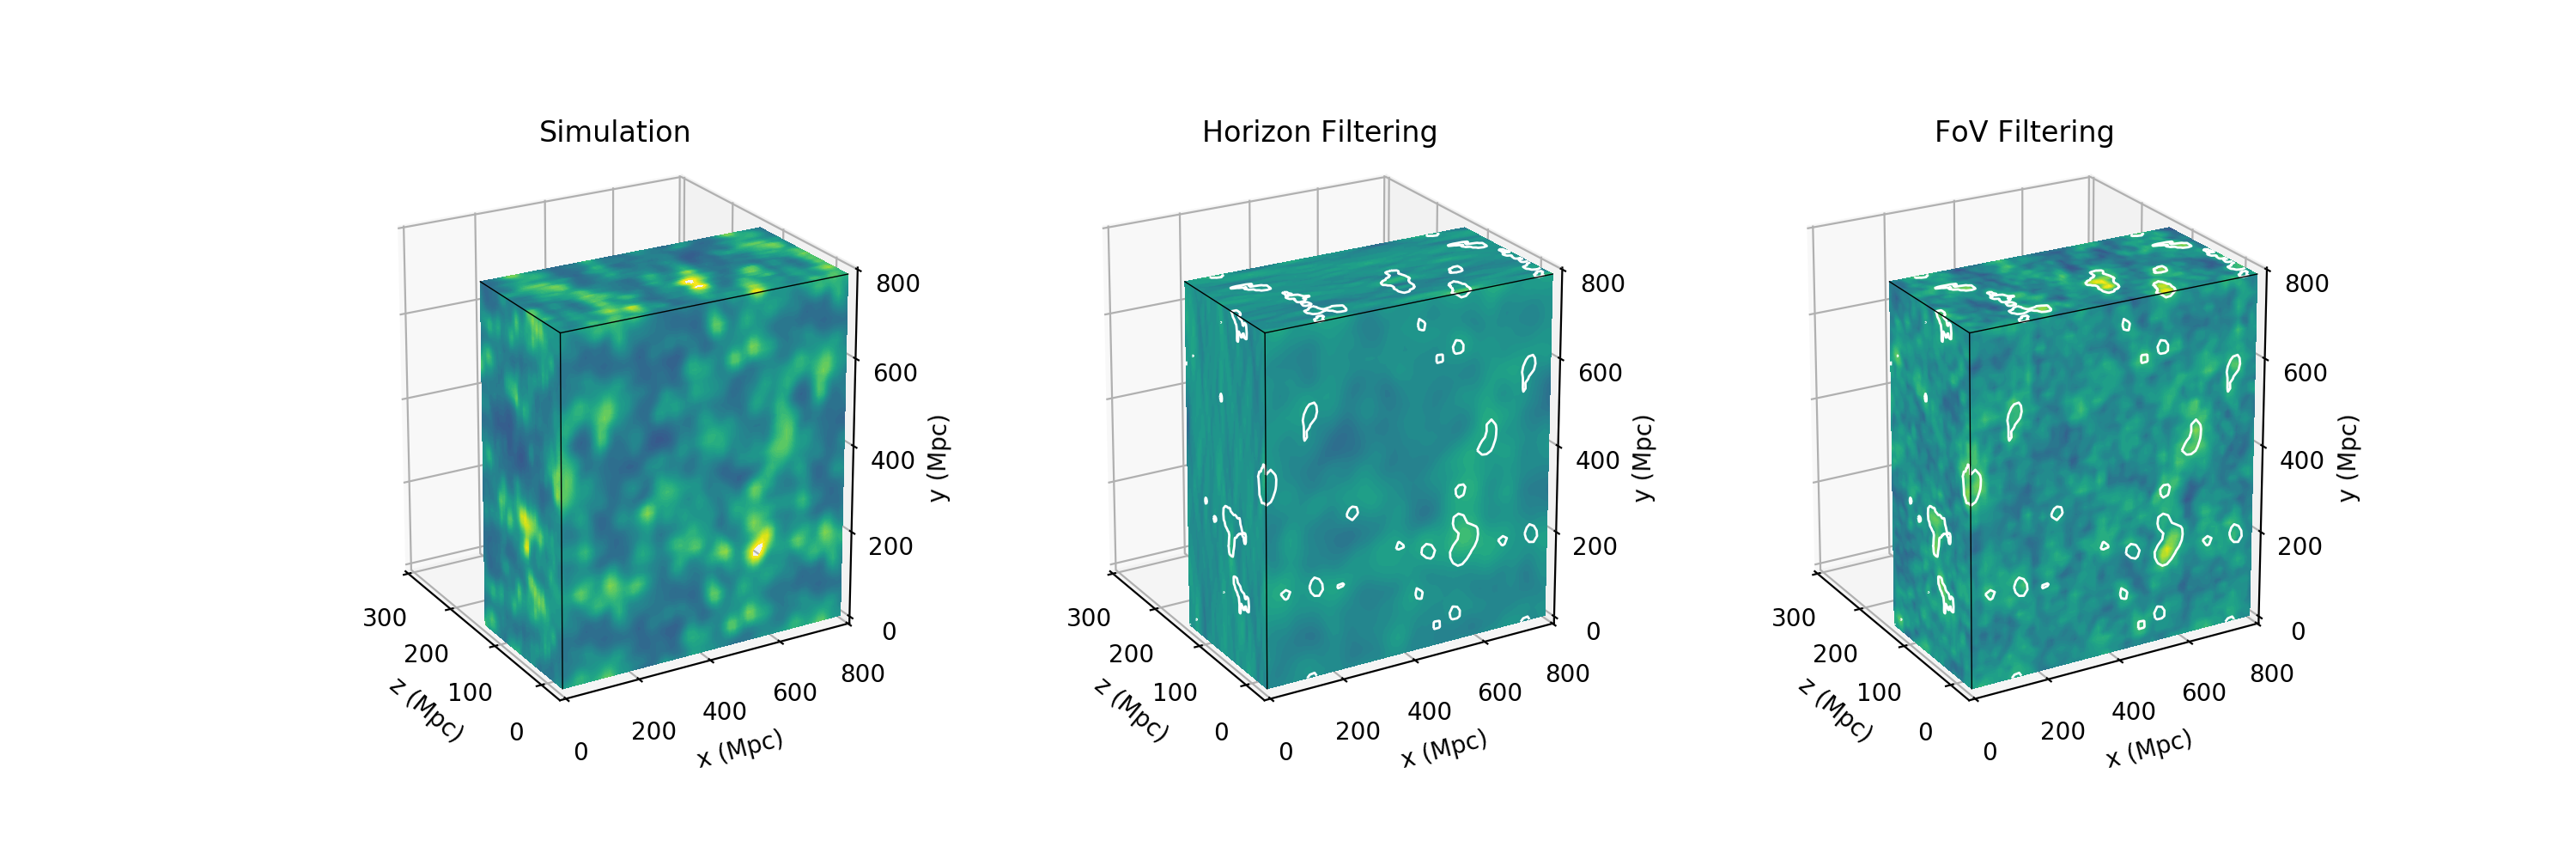

In [38]:
# 3D cube - Set of 3
vmax = [0.7*(tiled_cube).max()]
vmax += [0.7 * (f + n).max() for f, n in zip(filtered_images, filtered_noises)]
vmax[1] /= 0.5  # Compress scale for horizon to illustrate washing out
ncountours = 50
contour_alpha = 1 #0.75
contour_levels = [0.7 * vmax[0]]
contour_colors = ['white']
contour_linewidths = [1.0, .75]
inds_perp = filtered_images[0].shape[0] / 2
inds_par = filtered_images[0].shape[2]

X, Y, Z = np.meshgrid(obs_zaxis[:inds_par], obs_perpaxis[:inds_perp], obs_perpaxis[:inds_perp], indexing='ij')
X -= X.min()
ims = [(i[:inds_perp, :inds_perp, :inds_par] + n[:inds_perp, :inds_perp, :inds_par]).swapaxes(0, 2)
       for i, n in zip(filtered_images, filtered_noises)]
cim = tiled_cube[:inds_perp, :inds_perp, :inds_par].swapaxes(0, 2)

nplots = 3
fig = plt.figure(figsize=(5 * nplots, 5))

axs = []

## Reference cube
axs.append(fig.add_subplot(1, nplots, 1, projection='3d'))
axs[0].view_init(20, -30)
axs[0].contourf(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=2*X.max(),
                levels=np.linspace(0, vmax[0], ncountours))
axs[0].contourf(-X[:, 0, :] + 2*X.max(), cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                levels=np.linspace(0, vmax[0], ncountours))
axs[0].contourf(-X[:, :, -1] + 2*X.max(), Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                levels=np.linspace(0, vmax[0], ncountours))

for i in range(nplots - 1):
    axs.append(fig.add_subplot(1, nplots, i + 2, projection='3d'))
    axs[i + 1].view_init(20, -30)
    axs[i + 1].contourf(ims[i][-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset= 2 * X.max(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
    axs[i + 1].contourf(-X[:, 0, :] + 2*X.max(), ims[i][:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
    axs[i + 1].contourf(-X[:, :, -1] + 2*X.max(), Y[:, :, -1], ims[i][:, :, -1], zdir='z', offset=Z.max(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours), zorder=0)

    axs[i + 1].contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=2*X.max(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    axs[i + 1].contour(-X[:, 0, :] + 2*X.max(), cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    axs[i + 1].contour(-X[:, :, -1] + 2*X.max(), Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)


# Touch up axes
titles = ['Simulation', 'Horizon Filtering', 'FoV Filtering']
for i in range(nplots):
    axs[i].plot([2*X.max(), 2*X.max()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.5)
    axs[i].plot([X.max(), 2*X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)
    axs[i].plot([2*X.max(), 2*X.max()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.5)

#     axs[i].set_xlim3d((zaxis_h.max() - zaxis_h.min()), 0)
    axs[i].set_xlim3d(0, 2*(obs_zaxis.max() - obs_zaxis.min()))
    axs[i].xaxis.set_ticks(np.arange(0, 301, 100))
    axs[i].xaxis.set_ticklabels(np.arange(300, -1, -100))
    axs[i].set_xlabel('z (Mpc)')
    axs[i].set_ylim3d(Y.min(), Y.max())
    axs[i].yaxis.set_ticks(np.arange(0, 1000, 200))
    axs[i].set_ylabel('x (Mpc)')
    axs[i].set_zlim3d(Z.min(), Z.max())
    axs[i].zaxis.set_ticks(np.arange(0, 1000, 200))
    axs[i].set_zlabel('y (Mpc)')
    axs[i].set_title(titles[i])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


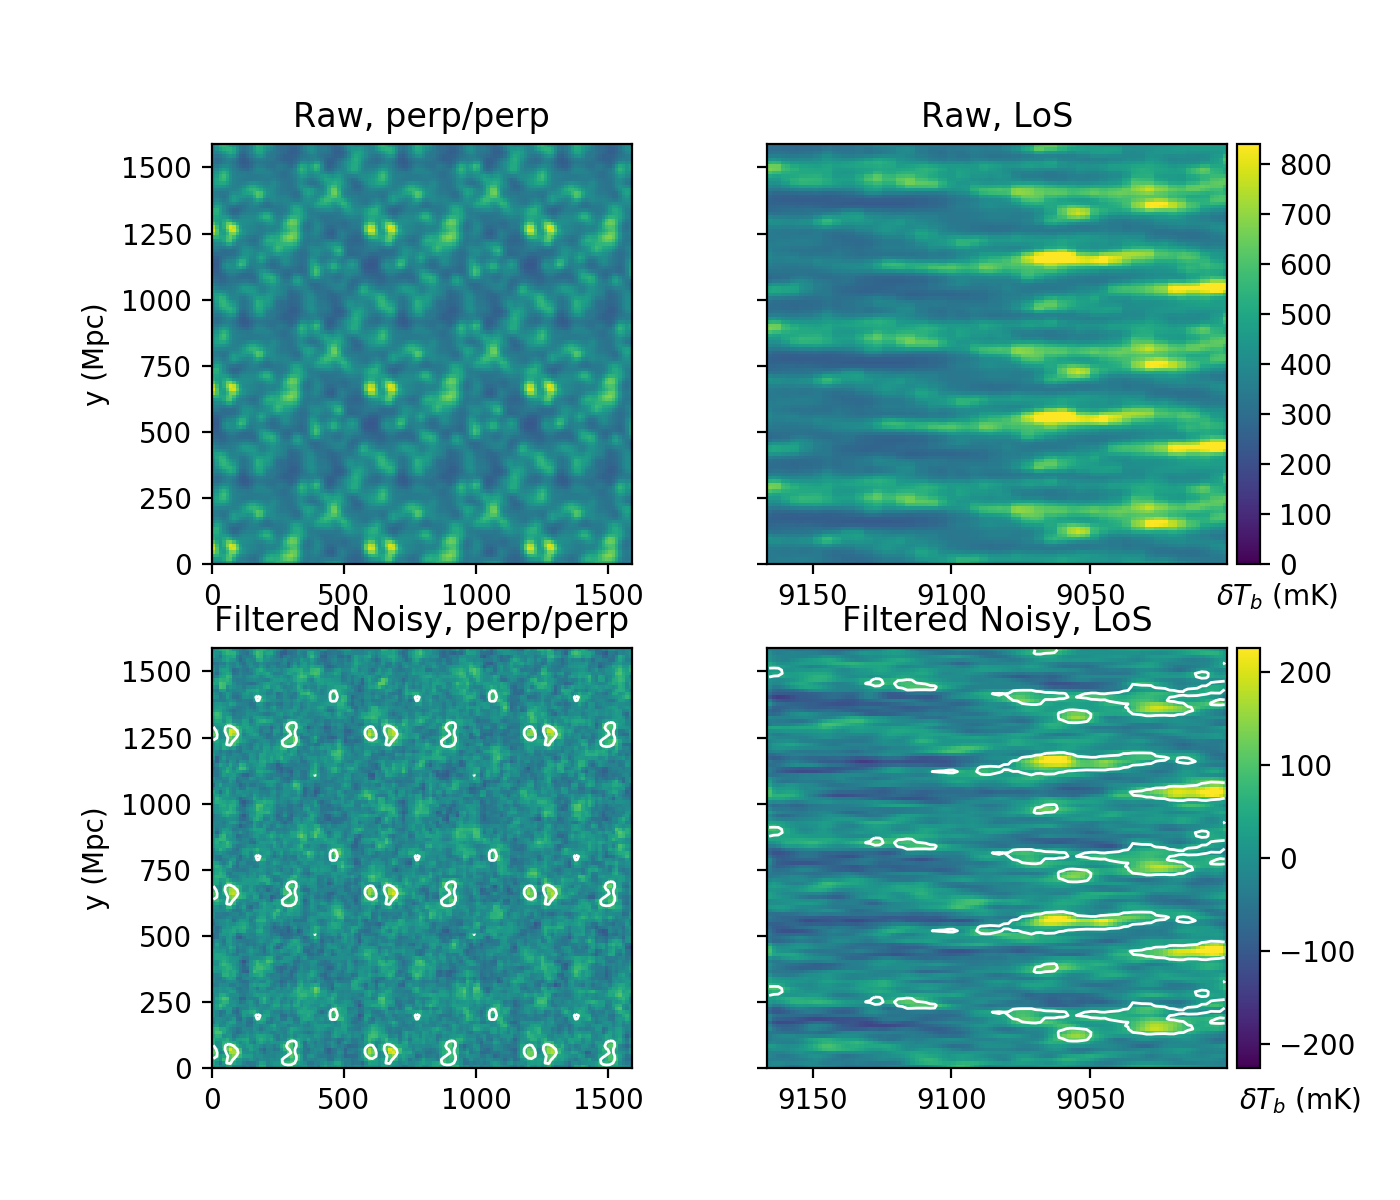

IndexError: list index out of range

In [25]:
# Plot 4-panels
for image_ind in range(3):
    f, ax = plt.subplots(2, 2, sharey=True, figsize=(7, 6))

    # perp perp cut, raw
    i, j = (0, 0)
    ind = tiled_cube.shape[2] / 2
    ext = [obs_perpaxis[0], obs_perpaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
    im = ax[i][j].imshow(tiled_cube[:, :, ind], extent=ext, aspect='equal', vmin=0, vmax=vmax[0])
    ax[i][j].set_ylabel('y (Mpc)')
    divider = make_axes_locatable(ax[i][j])
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cb = plt.colorbar(im, cax=cax)
#     cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
    ax[i][j].set_title('Raw, perp/perp');

    # perp perp cut, Horizon
    i, j = (1, 0)
    im = ax[i][j].imshow((filtered_images[image_ind] + filtered_noises[image_ind])[:, :, ind], extent=ext,
                         aspect='equal', vmin=-vmax[image_ind + 1], vmax=vmax[image_ind + 1])
    ax[i][j].set_ylabel('y (Mpc)')
    divider = make_axes_locatable(ax[i][j])
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cb = plt.colorbar(im, cax=cax)
#     cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
    ax[i][j].set_title('Filtered Noisy, perp/perp');
    ax[i][j].contour(tiled_cube[:, :, ind], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

    # LoS cut, raw
    i, j = (0, 1)
    ind = tiled_cube.shape[0] / 2
    ext = [obs_zaxis[0], obs_zaxis[-1], obs_perpaxis[0], obs_perpaxis[-1]]
    im = ax[i][j].imshow(tiled_cube[ind, :, :], extent=ext, aspect='auto', vmin=0, vmax=vmax[0])
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
    ax[i][j].set_title('Raw, LoS');

    # LoS cut, non-smoothed
    i, j = (1, 1)
    im = ax[i][j].imshow((filtered_images[image_ind] + filtered_noises[image_ind])[ind, :, :], extent=ext,
                         aspect='auto', vmin=-vmax[image_ind + 1], vmax=vmax[image_ind + 1])
    divider = make_axes_locatable(ax[i][j])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)
    ax[i][j].set_title('Filtered Noisy, LoS');
    ax[i][j].contour(tiled_cube[ind, :, :], extent=ext, origin='upper', colors=contour_colors,
                     alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

    plt.savefig(plotdir + 'Images_4panel_' + titles[image_ind + 1] + '_' + run_name + '_' + str(ndays) + '_days.pdf')

In [26]:
# Make Temp correlation plots
nbins_meas = 13
nbins_raw = 30
T_corrs = [np.zeros((nbins_meas, nbins_raw)) for i in range(3)]
nf_corrs = [np.zeros((nbins_meas, nbins_raw)) for i in range(3)]

X, Y = np.meshgrid(xmap, xmap)
ref_cube = hybrid_cube[Y, X, :]
ref_cube_nf = hybrid_cube_nf[Y, X, :]

for i in range(3):
    im = filtered_images[i].copy() + filtered_noises[i].copy()
    im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))

    for val in range(nbins_meas):
        ind = np.where(im == val)
        if len(ind[0]) == 0:
            T_corrs[i][val, :] = np.nan
            nf_corrs[i][val, :] = np.nan
        else:
            subcube = ref_cube[(ind[0], ind[1], ind[2])]
            subcube_nf = ref_cube_nf[(ind[0], ind[1], ind[2])]
            T_corrs[i][val, :] = np.histogram(ref_cube[(ind[0], ind[1], ind[2])],
                                              range=[ref_cube.min(), ref_cube.max()],
                                              bins=nbins_raw, density=True)[0]
            nf_corrs[i][val, :] = np.histogram(ref_cube[(ind[0], ind[1], ind[2])],
                                               range=[0, 1], bins=nbins_raw,
                                               density=True)[0]


/data4/beards/src/anaconda/envs/HERA/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins


<IPython.core.display.Javascript object>


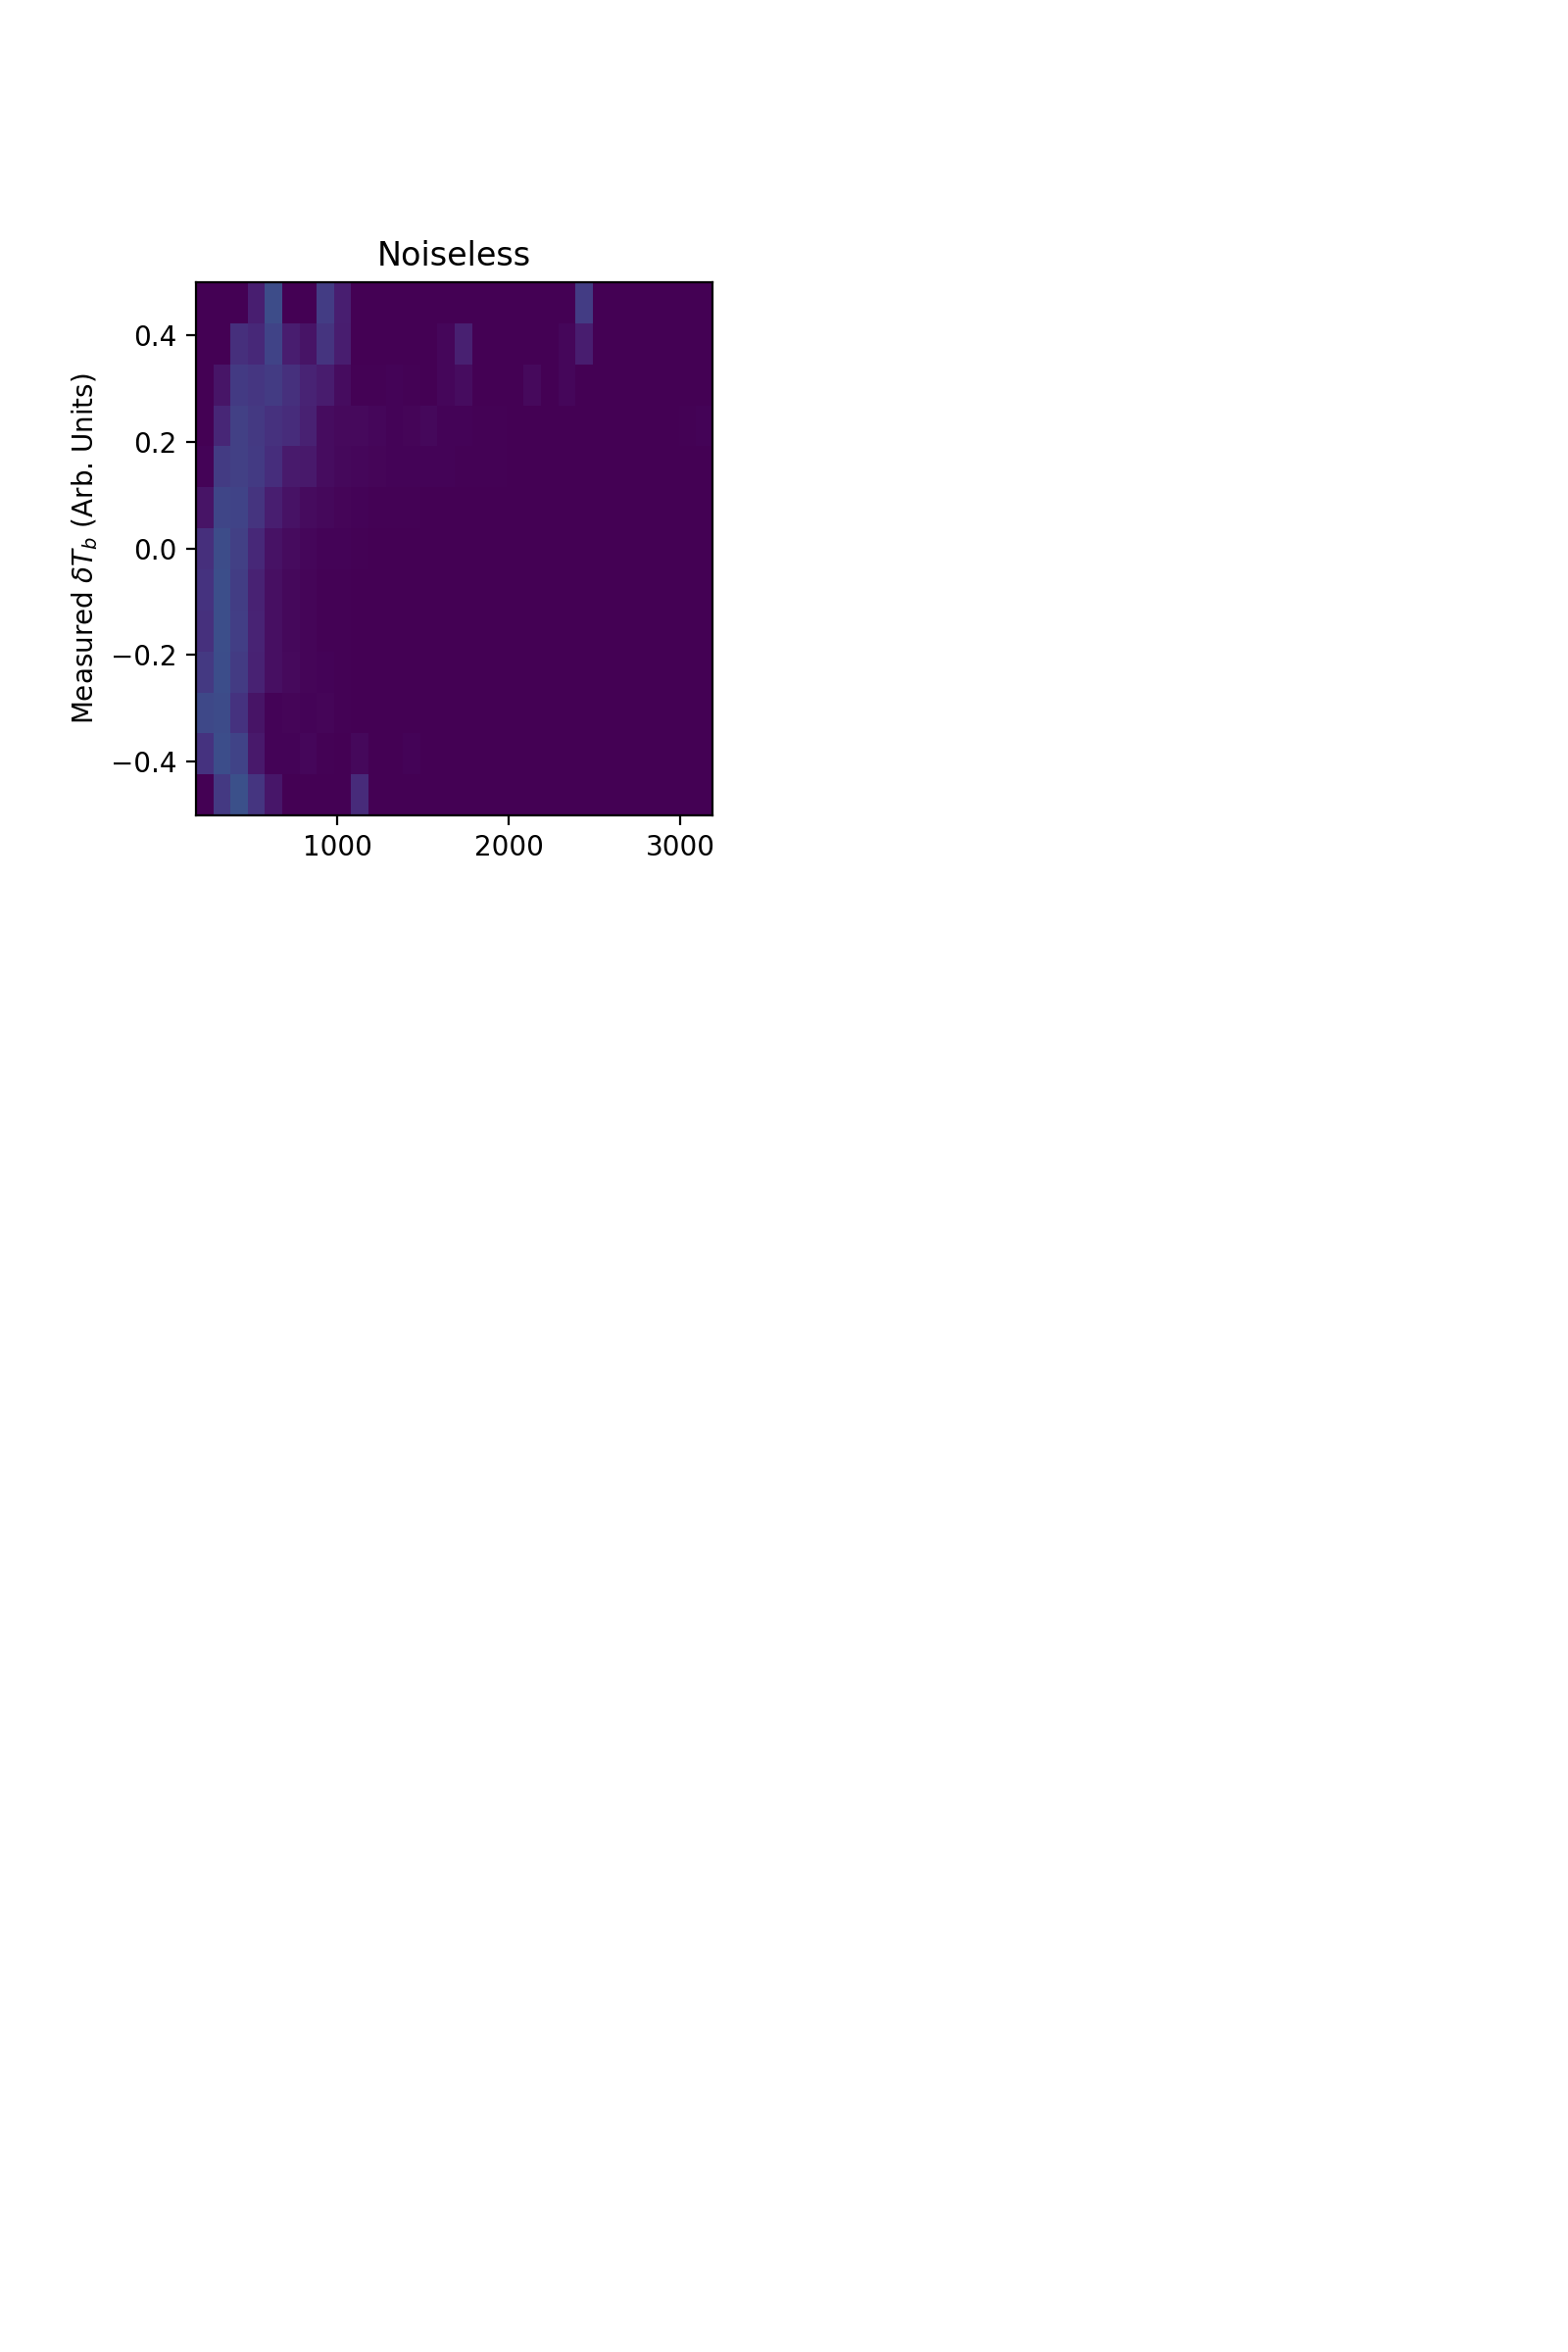

In [27]:
# Plot correlations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12), sharey=True)
ext = [ref_cube.min(), ref_cube.max(), -.5, .5]
ext_nf = [0, 1, -.5, .5]

for i in range(3):
    axes[i][0].imshow(T_corrs[i], aspect='auto', norm=SymLogNorm(linthresh=1e-3, vmin=0, vmax=1e2),
                      extent=ext, origin='lower')
    axes[i][0].set_title('Noiseless')
    axes[i][0].set_ylabel('Measured $\delta T_b$ (Arb. Units)')
    im = axes[i][1].imshow(nf_corrs[i], aspect='auto', norm=SymLogNorm(linthresh=1e-3, vmin=0, vmax=1e2),
                           extent=ext_nf, origin='lower')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.1, 0.02, .79])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Prob density', labelpad=-20, y=-0.04, rotation=0)

# plt.savefig(plotdir + 'Correlations_' + run_names[run_ind] + '_'+ wedge_mode + '_wedge_' + weighting + '_weighting_' + str(ndays) + '_days.pdf')

In [28]:
# Get probability curves
PDF_curves = []
ithresh = 0.98
nthresh = 0.5

for i in range(3):
    im = filtered_images[i].copy() + filtered_noises[i].copy()
    im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))
    pdf = np.zeros((nbins_meas, 2))  # ionized and neutral
    for val in range(nbins_meas):
        ind = np.where(im == val)
        if len(ind[0]) == 0:
            pdf[val, :] = [np.nan, np.nan]
        else:
            subcube = ref_cube_nf[(ind[0], ind[1], ind[2])]
            pdf[val, 0] = float(len(np.where(subcube < (1 - ithresh))[0])) / len(ind[0])
            pdf[val, 1] = float(len(np.where(subcube > nthresh)[0])) / len(ind[0])
    PDF_curves.append(pdf)
pdf_axis = np.linspace(-0.5, 0.5, nbins_meas)

<IPython.core.display.Javascript object>


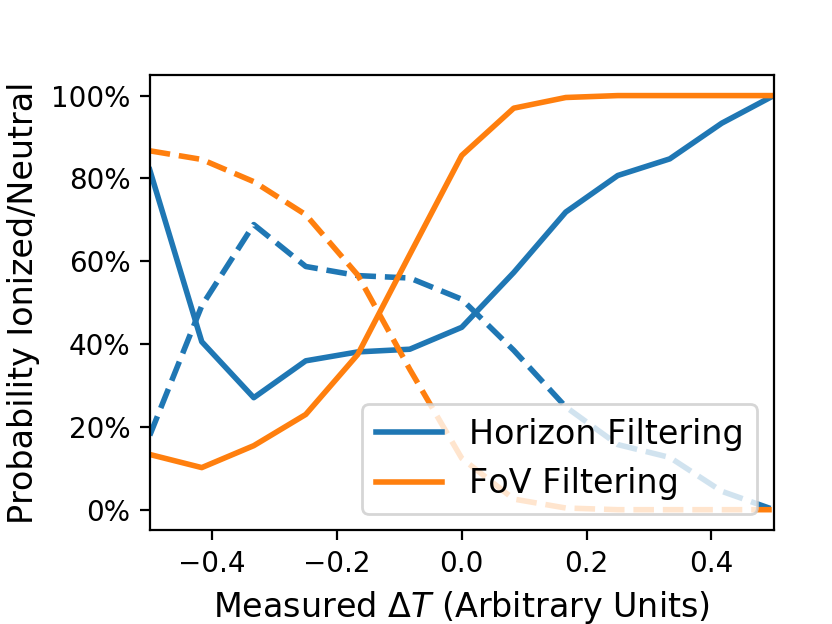

In [75]:
# Plot probability curves
from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(.65*6.4,.65*4.8))
for i in range(2):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(pdf_axis, PDF_curves[i][:, 0], color=color, label=titles[i + 1], linewidth=2)
    plt.plot(pdf_axis, PDF_curves[i][:, 1], '--', color=color, linewidth=2)
plt.xlabel('Measured $\Delta T$ (Arbitrary Units)', fontsize=12)
plt.ylabel('Probability Ionized/Neutral', fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xlim([-.5, .5])
# plt.ylim([0, 1])
plt.legend(fontsize=12, loc=4)
plt.gca().set_position([0.18, .15, 0.9-.15, .88-.15])  # Trial and error
plt.savefig(plotdir + 'Probability_' + run_name + '_'+ str(ndays) + '_days.pdf')

In [40]:
ax = plt.gca()

In [46]:
ax.get_position()

Bbox([[0.125, 0.15], [0.9, 0.88]])

In [50]:
ax.set_position([0.125, .15, .9-.125, .88-.15])